## DESI Classifier Performance: selecting for reobservation
#### Plot to show performance when selecting Lya QSOs for reobservation
In this notebook, we load the results from all of our classifiers on a DESI-like subset of the BOSS DR12Q Superset, and compare the results in the context of selecting high-z Lya QSOs for reobservation. We define different strategies for combining the classifiers' classifications, and assess which of these is preferable.

In [1]:
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import fitsio
from astropy.io import fits
from astropy.table import Table, join
from tensorflow.keras.models import load_model
from quasarnet.io import read_data
from quasarnet.utils import process_preds, absorber_IGM, Wave
%matplotlib inline

from quasarnet.io import read_truth
from qn_analysis import plot, variables
import desi_utils as utils

In [2]:
qnet_path = '/global/homes/j/jfarr/Projects/QuasarNET/'
figsize = (12,8)
fontsize = 18

plt.rc('font', size=fontsize)

### Load the results from the different classifiers

In [3]:
## General parameters
selections = ['SV0_QSO','MINI_SV_QSO']
expids = ['00055626','00055627','00055628']
common_targetids = False

## RR parameters

## QN parameters
n_lines = 1
c_th = 0.8
include_cmax_qn = True
include_cmax2_qn = True

## SQ parameters
p_min = 0.47
include_p_sq = True

In [4]:
f_truth = qnet_path+'/data/MiniSV/SV0/SV0_truth_tile68002_night20200315.fits'
truth = read_truth([f_truth])

In [5]:
data = {}

selection = 'SV0_QSO'
for expid in expids:

    ## Load the RR data.
    f_rr = '../rr_results/rr_SV0_{}.fits'.format(expid)
    data['RR {}'.format(expid)] = utils.load_rr_data(f_rr)

    ## Load the QN data.
    f_qn = '../qn_results/qn_SV0_{}_{}.fits'.format(expid,selection)
    data['QN {}'.format(expid)] = utils.load_qn_data(f_qn,n_lines=n_lines,c_th=c_th,include_cmax=include_cmax_qn,include_cmax2=include_cmax2_qn)

    ## Load the SQ data.
    f_sq = '../sq_results/sq_SV0_{}.fits'.format(expid)
    data['SQ {}'.format(expid)] = utils.load_sq_data(f_sq,p_min=p_min,include_p=include_p_sq)
    

/global/u1/j/jfarr/Projects/QuasarNET_DESI/notebooks/utils.py:116: RuntimeWarning: invalid value encountered in greater
  isqso = (data['prob']>p_min)


### Find the set of common targetids, and reduce all data to that set
This finds which targetids* are common to all datasets, and removes any that are not common. It then matches the data from each classifier to each targetid, and produces a single data table.

\* targetid = plate$\times$1000000000 + mjd$\times$10000 + fiber

In [6]:
data_table = utils.reduce_data_to_table(data,truth,
                                  include_cmax_qn=include_cmax_qn,
                                  include_cmax2_qn=include_cmax2_qn,
                                  include_p_sq=include_p_sq,
                                  common_targetids=common_targetids)
data_table[:5]

INFO: 917 common targetids


TARGETID,ZCONF_PERSON,Z_VI,CLASS_VI,ISQSO_VI,Z_RR 00055626,Z_QN 00055626,Z_SQ 00055626,Z_RR 00055627,Z_QN 00055627,Z_SQ 00055627,Z_RR 00055628,Z_QN 00055628,Z_SQ 00055628,CLASS_RR 00055626,CLASS_QN 00055626,CLASS_SQ 00055626,CLASS_RR 00055627,CLASS_QN 00055627,CLASS_SQ 00055627,CLASS_RR 00055628,CLASS_QN 00055628,CLASS_SQ 00055628,ISQSO_RR 00055626,ISQSO_QN 00055626,ISQSO_SQ 00055626,ISQSO_RR 00055627,ISQSO_QN 00055627,ISQSO_SQ 00055627,ISQSO_RR 00055628,ISQSO_QN 00055628,ISQSO_SQ 00055628,CMAX_QN 00055626,CMAX_QN 00055627,CMAX_QN 00055628,CMAX2_QN 00055626,CMAX2_QN 00055627,CMAX2_QN 00055628,P_SQ 00055626,P_SQ 00055627,P_SQ 00055628,ZWARN_RR 00055626,ZWARN_RR 00055627,ZWARN_RR 00055628
int64,int64,float64,str8,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,str8,str8,str8,str8,str8,str8,str8,str8,bool,bool,bool,bool,bool,bool,bool,bool,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64
35185923935178324,2,1.998,QSO,True,2.001,2.008,1.976,2.000,2.002,1.982,2.000,2.008,1.984,QSO,QSO,QSO,QSO,QSO,QSO,QSO,QSO,QSO,True,True,True,True,True,True,True,True,True,1.000,1.000,1.000,1.000,1.000,1.000,0.548,0.780,0.714,0,0,0
35185923939370065,2,-0.000,STAR,False,-0.000,1.646,nan,0.200,1.081,nan,0.583,2.603,nan,GALAXY,NONQSO,NONQSO,GALAXY,NONQSO,NONQSO,GALAXY,NONQSO,NONQSO,False,False,False,False,False,False,False,False,False,0.000,0.000,0.000,0.000,0.000,0.000,nan,nan,nan,0,4,4
35185923939371431,2,2.134,QSO,True,2.134,2.134,2.110,2.134,2.144,2.117,2.133,2.136,2.131,QSO,QSO,QSO,QSO,QSO,QSO,QSO,QSO,QSO,True,True,True,True,True,True,True,True,True,1.000,1.000,1.000,1.000,1.000,1.000,0.977,0.987,0.979,0,0,0
35185923939372655,2,1.507,GALAXY,False,1.507,2.618,nan,1.507,1.071,nan,1.507,1.606,0.921,GALAXY,NONQSO,NONQSO,GALAXY,NONQSO,NONQSO,GALAXY,NONQSO,NONQSO,False,False,False,False,False,False,False,False,False,0.000,0.000,0.001,0.000,0.000,0.001,nan,nan,0.171,0,0,0
35185923939373842,1,0.000,STAR,False,1.387,1.628,nan,0.168,1.879,0.888,0.643,2.560,nan,GALAXY,NONQSO,NONQSO,GALAXY,NONQSO,NONQSO,GALAXY,NONQSO,NONQSO,False,False,False,False,False,False,False,False,False,0.000,0.000,0.000,0.000,0.000,0.000,nan,0.160,nan,0,4,4


In [7]:
# Include only objects in the data table that have the highest confidence level.
data_table = data_table[data_table['ZCONF_PERSON']==2]
len(data_table)

697

### Evaluate performance of classifiers at selecting for reobservation.
xxx

In [8]:
def make_plot(fig,ax,data_table,strategies,filename,dv_max,eff_area=None,zcut=2.1,ymin=0.94,xmin=47.,xmax=52.,legend=True,xlabel=True,ylabel=True,n_highz_desi=50):

    # determine the true classifications
    isqso_truth = (data_table['ISQSO_VI'])
    isgal_truth = (data_table['CLASS_VI']=='GALAXY')
    isstar_truth = (data_table['CLASS_VI']=='STAR')
    isbad = ((data_table['CLASS_VI']=='BAD') | (data_table['ZCONF_PERSON']!=2))
    highz_truth = data_table['Z_VI']>=zcut

    points_occupied = []
    
    for s in strategies.keys():

        filt = strategies[s]['filter'] & (~isbad)
        if eff_area is None:
            eff_area = ((data_table['ISQSO_VI'] & (data_table['ZCONF_PERSON']==2) & (data_table['Z_VI']>=2.1) & filt).sum())/n_highz_desi

        strategies[s]['nhighz_flagged'] = np.zeros(len(strategies[s]['w']))
        strategies[s]['nhighz_truth_flagged'] = np.zeros(len(strategies[s]['w']))
        nhighz_truth = (highz_truth&isqso_truth&filt).sum()
                
        if ('QN' in s) or ('SQ' in s):
            for i,w in enumerate(strategies[s]['w']):
                w &= filt
                strategies[s]['nhighz_flagged'][i] = (w).sum()
                strategies[s]['nhighz_truth_flagged'][i] = (isqso_truth&highz_truth&w).sum()
                """print(s)
                print('true hz qsos:',nhighz_truth)
                print('obj flagged:',strategies[s]['nhighz_flagged'][0])
                print('true hz qsos flagged:',strategies[s]['nhighz_truth_flagged'][0])
                print('stars selected:',(isstar_truth&w).sum())
                print('gal selected:',(isgal_truth&w).sum())
                print('lowz qso selected:',(isqso_truth&(~highz_truth)&w).sum())
                print('')"""
        else:
            w = strategies[s]['w'][0] & filt
            strategies[s]['nhighz_flagged'][0] = (w).sum()
            strategies[s]['nhighz_truth_flagged'][0] = (isqso_truth&highz_truth&w).sum()

            c = s.split(' ')[0]
            e = s.split(' ')[1]
            zwarn = data_table['ZWARN_{} {}'.format(c,e)]>0
            """print(s)
            print('true hz qsos:',nhighz_truth)
            print('obj flagged:',strategies[s]['nhighz_flagged'][0])
            print('true hz qsos flagged:',strategies[s]['nhighz_truth_flagged'][0])
            print('obj with zwarn:',(filt&zwarn).sum())
            print('true hz qsos with zwarn:',(highz_truth&isqso_truth&filt&zwarn).sum())
            print('true hz qsos with zwarn missed:',(highz_truth&isqso_truth&filt&zwarn&(~strategies[s]['w'][0])).sum())
            print('stars selected:',(isstar_truth&w).sum())
            print('gal selected:',(isgal_truth&w).sum())
            print('lowz qso selected:',(isqso_truth&(~highz_truth)&w).sum())
            print('')"""
    
        reobs_dens = strategies[s]['nhighz_flagged']/eff_area
        pli = strategies[s]['nhighz_truth_flagged']/nhighz_truth
        if len(reobs_dens)>1:
            ax.plot(reobs_dens,pli,c='grey',marker=strategies[s]['marker'],label=s,zorder=2)
            points = ax.scatter(reobs_dens,pli,c=strategies[s]['color'],marker=strategies[s]['marker'],s=100,zorder=3)
        else:
            while (reobs_dens,pli) in points_occupied:
                reobs_dens *= 1.004
            print(s,reobs_dens,pli)
            points = ax.scatter(reobs_dens,pli,c=strategies[s]['color'],marker=strategies[s]['marker'],s=100,label=s,zorder=3)
            points_occupied += [(reobs_dens,pli)]
            
    """# Colour bar
    fig.subplots_adjust(right=0.87)
    cbar_ax = fig.add_axes([0.89, 0.15, 0.02, 0.7])
    cb = fig.colorbar(points,label=r'$c_{th}$',cax=cbar_ax)
    cb.mappable.set_clim(vmin=cth_min,vmax=cth_max)"""

    ax.axvline(x=n_highz_desi,c='k',zorder=1,ls='--')
    #text = 'assumed number density of\n'+r'high-$z$ QSOs in DESI [sqd$^{-1}$]'
    #ax.text(50.,1.004,text,va='center',ha='center')

    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,1.0+0.05*(1.-ymin))
    ax.grid()
    if legend:
        ax.legend(loc=4,ncol=1)
        
    if ylabel:
        ax.set_ylabel(r'fraction of high-$z$ QSOs reobserved')
    if xlabel:
        ax.set_xlabel(r'number density of fibers allocated to reobservations [sqd$^{-1}$]')
    ax.set_axisbelow(True)

    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0,decimals=1))

    # Shaded region.
    x = np.linspace(n_highz_desi*0.5,n_highz_desi*1.5,101)
    y = x/n_highz_desi
    y[x>n_highz_desi] = 1.
    ax.fill_between(x,y,np.ones_like(y)*1.1,edgecolor='darkgrey',facecolor='none',hatch='\\')

    """# Dashed lines for purities.
    p_values = [0.99,0.98,0.97,0.96,0.95]
    for p in p_values:
        p_contour = (x/50)*(p)
        ax.plot(x,p_contour,c='darkgrey')"""
    
    #plt.tight_layout()
    fig.subplots_adjust(wspace=0.1)
    plt.savefig(filename)

    return

/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/astropy/table/column.py:991: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)
/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/astropy/table/column.py:991: RuntimeWarning: invalid value encountered in greater_equal
  result = getattr(super(), op)(other)


QN 00055626 SV0_QSO [68.14814815] [0.91111111]
RR 00055626 SV0_QSO [57.03703704] [0.85555556]
SQ 00055626 SV0_QSO [66.66666667] [0.86666667]
QN|RR 00055626 SV0_QSO [71.85185185] [0.96666667]
SQ|RR 00055626 SV0_QSO [71.85185185] [0.94444444]
QN 00055627 SV0_QSO [66.66666667] [0.93333333]
RR 00055627 SV0_QSO [57.26518519] [0.85555556]
SQ 00055627 SV0_QSO [67.40740741] [0.88888889]
QN|RR 00055627 SV0_QSO [68.88888889] [0.96666667]
SQ|RR 00055627 SV0_QSO [71.11111111] [0.94444444]
QN 00055628 SV0_QSO [69.62962963] [0.94444444]
RR 00055628 SV0_QSO [57.03703704] [0.84444444]
SQ 00055628 SV0_QSO [62.96296296] [0.84444444]
QN|RR 00055628 SV0_QSO [71.11111111] [0.95555556]
SQ|RR 00055628 SV0_QSO [69.62962963] [0.93333333]


/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/astropy/table/column.py:991: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)
/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/astropy/table/column.py:991: RuntimeWarning: invalid value encountered in greater_equal
  result = getattr(super(), op)(other)


QN 00055626 MINI_SV_QSO [53.33333333] [0.92957746]
RR 00055626 MINI_SV_QSO [48.14814815] [0.91549296]
SQ 00055626 MINI_SV_QSO [49.62962963] [0.90140845]
QN|RR 00055626 MINI_SV_QSO [57.03703704] [1.]
SQ|RR 00055626 MINI_SV_QSO [54.07407407] [0.98591549]
QN 00055627 MINI_SV_QSO [52.59259259] [0.95774648]
RR 00055627 MINI_SV_QSO [45.18518519] [0.85915493]
SQ 00055627 MINI_SV_QSO [50.37037037] [0.92957746]
QN|RR 00055627 MINI_SV_QSO [54.29037037] [0.98591549]
SQ|RR 00055627 MINI_SV_QSO [51.85185185] [0.95774648]
QN 00055628 MINI_SV_QSO [52.59259259] [0.97183099]
RR 00055628 MINI_SV_QSO [45.36592593] [0.85915493]
SQ 00055628 MINI_SV_QSO [45.54738963] [0.85915493]
QN|RR 00055628 MINI_SV_QSO [53.33333333] [0.98591549]
SQ|RR 00055628 MINI_SV_QSO [50.37037037] [0.95774648]


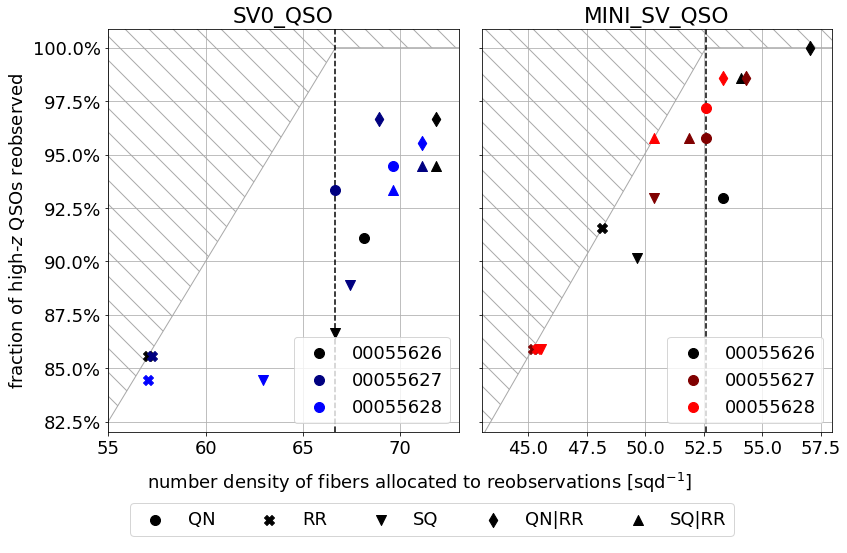

In [17]:
## Standard version of plot

eff_area = 1.35 #Want to use this 1.35
ymin = 0.82

# Object filters (for different targeting choices)
mini_sv_qso_data = fits.open(qnet_path+'/data/MiniSV/SV0/1exp/MiniSV_data_1exp_00055626_MINI_SV_QSO_lmax9800.fits')
mini_sv_qso_tids = mini_sv_qso_data[1].data['TARGETID']
mini_sv_qso_data.close()
filters = {'SV0_QSO': np.ones(len(data_table)).astype('bool'),
           'MINI_SV_QSO': np.in1d(data_table['TARGETID'],mini_sv_qso_tids),
          }

# Number of expected high-z QSOs per square degree in DESI
true_highzqso = data_table['ISQSO_VI']&(data_table['Z_VI']>=2.1)
n_highz_desi = {'SV0_QSO': (true_highzqso&filters['SV0_QSO']).sum()/eff_area, 
                'MINI_SV_QSO': (true_highzqso&filters['MINI_SV_QSO']).sum()/eff_area, }
xmin = {'SV0_QSO': 55, 'MINI_SV_QSO': 43}
xmax = {'SV0_QSO': 73, 'MINI_SV_QSO': 58}

# Cut to define high-z QSOs.
zcut = 2.1
# Maximum velocity error to be considered a correct classification.
dv_max = 6000. # km/s

# confidence thresholds.
cth_min = 0.0
cth_max = 1.0
n_int = 10
c_th = np.arange(cth_min,cth_max,(1/n_int)*(cth_max-cth_min))
c_th_choice = {'SV0_QSO': 0.4,
                'MINI_SV_QSO': 0.35}
p_min_choice = {'SV0_QSO': 0.2,
                'MINI_SV_QSO': 0.2}

# Make the figure.
filename = '../plots/classifier_performance_selecting_for_reobservation_tile68002_night20200315.pdf'
fig, axs = plt.subplots(1,2,figsize=(figsize[0],figsize[1]),sharey=True)

# Make the panels.
for j,selection in enumerate(filters.keys()):

    strategies = {}
    for i,expid in enumerate(expids):

        # QN classifications.
        isqso_qn = (data_table['CMAX_QN {}'.format(expid)]>c_th_choice[selection])
        highz_qn = data_table['Z_QN {}'.format(expid)]>=zcut
        w_qn = [isqso_qn & highz_qn]
        #w_qn = [(data_table['CMAX_QN {}'.format(expid)]>cth)& highz_qn for cth in c_th]

        # RR classifications.
        isqso_rr = data_table['ISQSO_RR {}'.format(expid)]
        highz_rr = (data_table['Z_RR {}'.format(expid)]>=zcut)

        # SQ classifications.
        isqso_sq = (data_table['P_SQ {}'.format(expid)]>p_min_choice[selection])
        highz_sq = data_table['Z_SQ {}'.format(expid)]>=zcut

        c = np.zeros(3)
        c[(j-1)%3] = (i)/(len(expids)-1)

        strategies['QN {} {}'.format(expid,selection)] = {
                            'w': w_qn,
                            'color': [c]*len(w_qn),
                            'marker': 'o',
                            'filter': filters[selection]
                           }

        strategies['RR {} {}'.format(expid,selection)] = {
                            'w': [isqso_rr & highz_rr],
                            'color': [c],
                            'marker': 'X',
                            'filter': filters[selection]
                           }

        strategies['SQ {} {}'.format(expid,selection)] = {
                            'w': [isqso_sq & highz_sq],
                            'color': [c],
                            'marker': 'v',
                            'filter': filters[selection]
                           }
        
        strategies['QN|RR {} {}'.format(expid,selection)] = {
                            'w': [w|(isqso_rr & highz_rr) for w in strategies['QN {} {}'.format(expid,selection)]['w']],
                            'color': [c]*len(w_qn),
                            'marker': 'd',
                            'filter': filters[selection]
                            }

        strategies['SQ|RR {} {}'.format(expid,selection)] = {
                            'w': [w|(isqso_rr & highz_rr) for w in strategies['SQ {} {}'.format(expid,selection)]['w']],
                            'color': [c],
                            'marker': '^',
                            'filter': filters[selection]
                            }

        """strategies['QN|SQ|RR {} {}'.format(expid,selection)] = {
                            'w': [w_qn|w_sq|(isqso_rr & highz_rr) for w_sq in strategies['SQ {} {}'.format(expid,selection)]['w'] for w_qn in strategies['QN {} {}'.format(expid,selection)]['w']],
                            'color': [c],
                            'marker': '*',
                            'filter': filters[selection]
                            }"""

         
    make_plot(fig,axs[j],data_table,strategies,filename,dv_max,eff_area=eff_area,zcut=zcut,ymin=ymin,xmin=xmin[selection],xmax=xmax[selection],legend=False,xlabel=False,ylabel=(j==0),n_highz_desi=n_highz_desi[selection])
    artists = []
    labels = []
    for i,expid in enumerate(expids):
        ## Add colour blobs to legend for exposure id
        c = np.zeros(3)
        c[(j-1)%3] = (i)/(len(expids)-1)
        artists += [axs[j].scatter([],[],color=c,s=100)]
        labels += ['{}'.format(expid)]
    axs[j].legend(artists,labels,ncol=1,loc=4)
    axs[j].set_title(selection)

artists = []
labels = []
markers = {k.split(' ')[0]: strategies[k]['marker'] for k in strategies.keys()}
for s in markers:
    ## Add marker shapes for strategy
    artists += [axs[0].scatter([],[],color='k',marker=markers[s],s=100)]
    labels += ['{}'.format(s)]
    
fig.legend(artists,labels,loc='lower center',borderaxespad=0,bbox_to_anchor=(0.5,0.03),ncol=len(artists))
rect = (0,0.15,1.,1.)
plt.tight_layout(rect=rect)
fig.text(0.5,0.14,r'number density of fibers allocated to reobservations [sqd$^{-1}$]',ha='center',va='center')
    
plt.savefig(filename)
plt.show()